# MODELISATION DU COMPORTEMENT D'ARBITRAGE EN ASSURANCE VIE

In [1]:
!pip install openpyxl -q
!pip install yahoo_fin --upgrade -q
!pip install missingno -q
!pip install requests beautifulsoup4 -q

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso
import math
import requests
from bs4 import BeautifulSoup

from scipy.stats import gmean, f_oneway
from datetime import datetime, timezone
from yahoo_fin.stock_info import get_data

In [3]:
import os
os.getcwd()

'/home/onyxia/work/Arbitrage_Vie_BNP_Cardif'

In [4]:
base = pd.read_excel("Base_ENSAE_2021_corr.xlsx", sheet_name="Données")

In [5]:
base.head()

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,montant_corr,NB_UC_corr,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr,Unnamed: 104,Unnamed: 105
0,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ARBITRAGES SUR LE FOND GENERAL
### Feature Engineering

##### Dans cette première partie nous commençons par le calcul de la variable Taux d'arbritrage de fond en euro vers Unité compte

In [6]:
#Base de données des opérations sur le fond Général (toutes les opérations incluant le FG)
base_operation_FG = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('FG')]

#Variables temporelles d'arbitrage (année et mois)
base_operation_FG['annee_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_FG['mois_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(4, 6)

In [7]:
#Base de données des opérations sur les Unités de Compte (toutes les opérations incluant le UC)
base_operation_UC = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('UC')]

#Variables temporelles d'arbitrage (année et mois)
base_operation_UC['annee_operation'] =  base_operation_UC['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_UC['mois_operation'] =  base_operation_UC['Anmois_operation'].astype(str).str.slice(4, 6)

In [8]:
# regroupement par contrats et par Anmois_operation
base_operation_regroupee_UC = base_operation_UC.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [9]:
# regroupement par contrats et par Anmois_operation
base_operation_regroupee_FG = base_operation_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [10]:
base_operation_FG["operation"].unique()

array(['rachat partiel', 'Arbitrages entrants du FG',
       'Arbitrages sortants du FG', 'primes programmées',
       'rachat programmé', 'décès', 'versement libre', 'PS sur décès',
       'rachat total'], dtype=object)

##### Calcul des PM_UC actualisées après chaque opération impliquant UC

In [11]:
### Pour chaque opération qui inclut un UC, on actualise la valeur de la PM après cette opération
base_operation_UC["PM_UC_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_UC:
    liste_index = list(groupe.index)
    base_operation_UC.loc[[liste_index[-1]], "PM_UC_actualisee"] = base_operation_UC.loc[[liste_index[-1]], "PM_UC"].values[0] - base_operation_UC.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant UC
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else: 
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_UC.loc[[index], "PM_UC_actualisee"] = base_operation_UC.loc[[liste_index[position-1]], "PM_UC_actualisee"].values[0] - montant_operation
        

##### Calcul des PM_FG actualisées après chaque opération impliquant le FG

In [13]:
### Pour chaque opération qui inclut le Fond G, on actualise la valeur de la PM après cette opération
base_operation_FG["PM_FG_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_FG:
    liste_index = list(groupe.index)
    base_operation_FG.loc[[liste_index[-1]], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[-1]], "PM_FG"].values[0] - base_operation_FG.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant le fonds FG
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else: 
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_FG.loc[[index], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[position-1]], "PM_FG_actualisee"].values[0] - montant_operation
        

In [15]:
#Base multisupports et UC-pures à laquelle on ajoute la colonne "PM_UC_actualisee"
base_multisupport_UCpures = base.dropna(subset = ['support'])[base.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG', 'UC pures' )]
base_multisupport_UCpures["PM_UC_actualisee"]=np.nan

#Mise à jour de la base des multissupports et UC pures pour les PM Actualisées
base_multisupport_UCpures.update(base_operation_UC)

In [73]:
#Calcul des taux d'arbitrage sortant UC

###Le calcul des taux UC->FG et UC -> UC se fait sur l'hypothèse d'une base bien ordonnée; 
#c'est à dire en supposant que lorsqu'il y'a un arbitrage sortant de UC, l'opération de sortie des UC est d'abord enregistrée, et:
#--- si le montant va directement dans une autre UC, alors l'opération d'entrée dans l'UC suit l'opération de sortie
#--- si le montant va directement dans le Fonds G, alors l'opération d'entrée dans le FG suit directement l'opération de sortie de l'UC
#--- enfin, si le montant se reparti entre une UC et le FG, l'opération d'entrée est enregistrée après l'opération de sortie de l'UC, 
#et l'opération d'entrée dans le FG est enregistrée après l'opération d'entrée dans l'UC

##Peu à peu, d'autres cas ont été identifiés et géré avec la condition if
base_multisupport_UCpures["r_UC_UC"] = 0
base_multisupport_UCpures["r_UC_FG"] = 0
seuil = 30 ## Explication
base_operation_regroupee_MultiS_UCp = base_multisupport_UCpures.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

for (contrat, date), groupe in base_operation_regroupee_MultiS_UCp:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants des UC':
            PM = ligne['PM_UC_actualisee']
            montant_sortant = ligne['mtt_arbs_corr'] * (-1)
            try :
                if (montant_sortant - groupe.loc[[index+1], "mtt_arbe_corr"].values[0]  <= seuil) & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                elif (montant_sortant - groupe.loc[[index+1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                elif (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages sortants du FG') & (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index], "mtt_arbs_corr"].values[0]/PM
                elif (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages sortants du FG') & (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index], "mtt_arbs_corr"].values[0]/PM
                    
                elif (groupe.loc[[index+1], "operation"].values[0] == 'Arbitrages entrants des UC') & (groupe.loc[[index+2], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index+2], "mtt_arbe_corr"].values[0]/PM   
            except: #Dans le cas où l'arbitrage de sortie UC n'est pas enregistré en 1er, on permute donc les lignes, avant les calculs
                if (montant_sortant - groupe.loc[[index-1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index-1], "operation"].values[0] == 'Arbitrages entrants des UC'):
                    base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index-1], "mtt_arbe_corr"].values[0]/PM
                elif (montant_sortant - groupe.loc[[index-1], "mtt_arbe_corr"].values[0] <= seuil) & (groupe.loc[[index-1], "operation"].values[0] == 'Arbitrages entrants du FG'):
                    base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index-1], "mtt_arbe_corr"].values[0]/PM


#Update des taux Uc_Uc qui sont supérieurs à 1
base_multisupport_UCpures.loc[base_multisupport_UCpures['r_UC_UC']>1, 'r_UC_UC'] = 1

#Update des taux Uc_Fg qui sont supérieurs à 1
base_multisupport_UCpures.loc[base_multisupport_UCpures['r_UC_FG']>1, 'r_UC_FG'] = 1

/tmp/ipykernel_642/1715313427.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09623844375952505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  base_multisupport_UCpures.loc[[index],"r_UC_FG"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
/tmp/ipykernel_642/1715313427.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3580206519106847' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM
/tmp/ipykernel_642/1715313427.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  base_multisupport_UCpures.loc[[index],"r_UC_UC"] = groupe.loc[[index+1], "mtt_arbe_corr"].values[0]/PM


In [74]:
#Base des arbitrages sortants du FG (tous les arbitrages sortant du FG)
base_arbitrage_FG = base_operation_FG.dropna(subset = ['operation'])[base_operation_FG.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base d'arbitrages regroupée
base_arbitrage_regroupee_FG = base_arbitrage_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [75]:
# Calcul des taux d'arbitrage sortant FG
base_arbitrage_FG["r_FG"]=0
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants du FG':
            montant_operation = ligne['mtt_arbs_corr'] * (-1)
            base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]
            
        

/tmp/ipykernel_642/1469806560.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9956622696078706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]


Mensualisation des taux 

In [117]:
##I- Taux r_FG
taux_mensuels = pd.DataFrame()
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    prd_scl = np.dot(groupe["r_FG"], groupe["PM_FG_actualisee"])
    somme = (np.sum(groupe["PM_FG_actualisee"]))
    taux = 1 - (1 - prd_scl/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_FG_m" : [taux]})
    taux_mensuels = pd.concat([taux_mensuels, ligne])


##I- Taux Uc_Uc et Uc_FG
taux_mensuels_2 = pd.DataFrame()

base_multisupport_UCpures2 = base_multisupport_UCpures.dropna(subset=['PM_UC_actualisee'], how='all')
base_operation_regroupee_MultiS_UCp2 = base_multisupport_UCpures2.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

for (contrat, date), groupe in base_operation_regroupee_MultiS_UCp2:
    prd_scl1 = np.dot(groupe["r_UC_UC"], groupe["PM_UC_actualisee"])
    prd_scl2 = np.dot(groupe["r_UC_FG"], groupe["PM_UC_actualisee"])
    somme = (np.sum(groupe["PM_UC_actualisee"]))
    taux_uc_uc = 1 - (1 - prd_scl1/somme)**30
    taux_uc_fg = 1 - (1 - prd_scl2/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_UC_UC_m" : [taux_uc_uc], "r_UC_FG_m" : [taux_uc_fg] })
    taux_mensuels_2 = pd.concat([taux_mensuels_2, ligne])

In [100]:
base_multisupport_UCpures[base_multisupport_UCpures["n_sous"]==938][["n_sous", "Anmois_operation", "CD_TYPE_SUP","PM_UC_actualisee"]]

,n_sous,Anmois_operation,CD_TYPE_SUP,PM_UC_actualisee
12065,938,202101.0,UC,222687.865048
12066,938,202101.0,FG,NaN
12067,938,202102.0,UC,253705.045173
12068,938,202102.0,FG,NaN
12069,938,202103.0,UC,240517.199495
12070,938,202103.0,FG,NaN
12071,938,202104.0,UC,272624.969987
12072,938,202104.0,UC,187894.519987
12073,938,202104.0,UC,272624.959987
12074,938,202104.0,FG,NaN


In [118]:
base_multisupport_UCpures2[base_multisupport_UCpures2["n_sous"]==938][["n_sous", "Anmois_operation", "CD_TYPE_SUP", "PM_UC_actualisee", "r_UC_UC", "r_UC_FG"]]

,n_sous,Anmois_operation,CD_TYPE_SUP,PM_UC_actualisee,r_UC_UC,r_UC_FG
12065,938,202101.0,UC,222687.865048,0.000000,0.000000
12067,938,202102.0,UC,253705.045173,0.000000,0.097547
12069,938,202103.0,UC,240517.199495,0.000000,0.000000
12071,938,202104.0,UC,272624.969987,0.310795,0.000000
12072,938,202104.0,UC,187894.519987,0.000000,0.000000
12073,938,202104.0,UC,272624.959987,0.000000,0.000000
12075,938,202105.0,UC,297478.957018,0.122054,0.000000
12076,938,202105.0,UC,261170.467018,0.000000,0.000000
12077,938,202105.0,UC,297478.947018,0.000000,0.175881
12079,938,202106.0,UC,249021.346479,0.060699,0.000000


In [25]:
base_arbitrage_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee', 'r_FG']].head(5)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee,r_FG
79,7,202102.0,Arbitrages sortants du FG,0.000000,-24371.62,24371.620000,1.000000
125,10,202110.0,Arbitrages sortants du FG,88.624841,-20342.53,20431.154841,0.995662
179,16,202104.0,Arbitrages sortants du FG,470438.720241,-52139.56,522578.280241,0.099774
264,24,202103.0,Arbitrages sortants du FG,367709.366491,-59695.05,427404.416491,0.139669
272,24,202109.0,Arbitrages sortants du FG,338764.925935,-29373.86,368138.785935,0.079790


In [120]:
# Regroupement de la base des taux mensuels
arbitrage_m_regroupee_FG = taux_mensuels.groupby(by= 'n_sous', as_index = False)
arbitrage_m_regroupee_UC = taux_mensuels_2.groupby(by= 'n_sous', as_index = False)



Annualisation des taux 

In [121]:
##I- Taux r_FG
taux_annuels = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_FG:
    taux = 1 - (np.prod(1 - groupe["r_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_FG_a" : [taux]})
    taux_annuels = pd.concat([taux_annuels, ligne])

##I- Taux Uc_Uc et Uc_FG
taux_annuels_2 = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_UC:
    taux1 = 1 - (np.prod(1 - groupe["r_UC_UC_m"])) 
    taux2 = 1 - (np.prod(1 - groupe["r_UC_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_UC_UC_a" : [taux1], "r_UC_FG_a" : [taux2] })
    taux_annuels_2 = pd.concat([taux_annuels_2, ligne])



In [122]:
# Fusion des bases pour pouvoir faire correspondre à chaque contrat ses taux d'arbitrage mensualisés et annualisés
base_updte = pd.merge(base, taux_mensuels, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_mensuels_2, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels, how="left", on="n_sous", suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels_2, how="left", on="n_sous", suffixes=(None, None))
base_updte['r_FG_a'] = base_updte['r_FG_a'].fillna(0)
base_updte['r_FG_m'] = base_updte['r_FG_m'].fillna(0)
base_updte['r_UC_UC_m'] = base_updte['r_UC_UC_m'].fillna(0)
base_updte['r_UC_UC_a'] = base_updte['r_UC_UC_a'].fillna(0)
base_updte['r_UC_FG_m'] = base_updte['r_UC_FG_m'].fillna(0)
base_updte['r_UC_FG_a'] = base_updte['r_UC_FG_a'].fillna(0)

In [123]:
base_updte[["n_sous", "r_FG_m", "r_FG_a", "r_UC_UC_m", "r_UC_UC_a", "r_UC_FG_m", "r_UC_FG_m", "r_UC_FG_a", "r_UC_FG_a"]].sample(60)

,n_sous,r_FG_m,r_FG_a,r_UC_UC_m,r_UC_UC_a,r_UC_FG_m,r_UC_FG_m,r_UC_FG_a,r_UC_FG_a
35487,2578,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
112360,8946,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
108631,8674,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8280,668,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
94710,7532,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16679,1253,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
96790,7715,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58947,4433,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115541,9194,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5112,415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# DESCRIPTION DE LA BASE DE DONNEES 

### 1. Aperçu général de la base de données :

#### Nombre total d'observations et de variables :

In [28]:
print(base.shape)
print("\n Liste des varaibles de la base :\n")
base.columns.tolist()

(119479, 106)

 Liste des varaibles de la base :



['n_sous',
 'Anmois_eff_sous',
 'Anmois_eff_fisc',
 'TOP_2TETE',
 'COD_BEN_DC',
 'COD_BEN_VIE',
 'TOP_BEN_ACPT',
 'MTTC_PRI_REG_ORIG',
 'MT_PRS_VRS_ORIG',
 'MTTC_PRI_INV_ANN',
 'MTTC_PRI_INV_AP',
 'MTTC_PRI_ECH_NRAC',
 'MT_VRAC_SOUS',
 'COD_POS_SOUS',
 'COD_VRS',
 'Anmois_eff_mvt',
 'Anmois_ter_sous',
 'MTTC_PP_ACTU',
 'MBRUT_MVT',
 'COD_MVT_SC',
 'ID_PRD',
 'TOP_MEG',
 'TOP_NUPROP',
 'TOP_COSOUS',
 'TOP_K_DEMBRT',
 'TOP_PROCU',
 'MTTC_PRI_FISC98',
 'MT_VAC_FISC98',
 'DUR_SOUS',
 'Anmois_sign_sous',
 'TOP_DEROG_FRAIS_ARB',
 'TOP_CONTRAT_DIVERSIFIE',
 'MT_CGT_REEL',
 'COD_TYP_MANDAT',
 'TOP_HANDICAP',
 'reseau_fin',
 'Anmois_arrete',
 'CODPTT',
 'COD_CSP',
 'COD_FIS',
 'COD_SIT_FAM',
 'NB_ENF_CHR',
 'Anmois_DC',
 'COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI',
 'TOP_2ASS',
 'BDIS',
 'TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT',
 'L_VIL_NAIS',
 'COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS

#### Type de données pour chaque variable : 

In [29]:
base.dtypes

n_sous                 int64
Anmois_eff_sous        int64
Anmois_eff_fisc        int64
TOP_2TETE              int64
COD_BEN_DC             int64
                      ...   
mtt_vers_ann_corr    float64
mtt_arbs_corr        float64
mtt_arbe_corr        float64
Unnamed: 104         float64
Unnamed: 105         float64
Length: 106, dtype: object

#### Statistiques descriptives de base :

In [30]:
Variables_retenues=['n_sous','support','Anmois_sign_sous','Anmois_naissance','Sexe','COD_TYP_MANDAT','COD_CSP','COD_SIT_FAM',
                       'NB_ENF_CHR','COD_T_CLI','COD_POS_CLI','COD_CAT_CLI','TOP_RENT','COD_PAYS']
base[Variables_retenues].describe()

,n_sous,Anmois_sign_sous,Anmois_naissance,COD_TYP_MANDAT,COD_CSP,COD_SIT_FAM,NB_ENF_CHR,COD_T_CLI,COD_POS_CLI,COD_CAT_CLI,TOP_RENT
count,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000,119479.000000
mean,4629.559019,199462.385649,194566.406473,0.104052,7.284678,4.312289,1.007876,2.164221,1.219361,1.160857,0.000201
std,2783.619962,534.376926,1429.420622,0.315468,22.037171,4.197793,2.836007,1.014355,0.634032,0.606517,0.014172
min,1.000000,197404.000000,191103.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2177.000000,199209.000000,193501.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000
50%,4501.000000,199309.000000,194504.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000,0.000000
75%,7077.000000,199611.000000,195404.000000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,1.000000,0.000000
max,9507.000000,201909.000000,201003.000000,4.000000,99.000000,9.000000,9.000000,8.000000,9.000000,7.000000,1.000000


### 2. Analyse des valeurs manquantes :

#### Identifiez les variables avec des valeurs manquantes

In [31]:
missing_values = base[Variables_retenues].isnull().sum()
print("\n Analyse des valeurs manquantes : ")
print(missing_values[missing_values > 0])


 Analyse des valeurs manquantes : 
COD_PAYS    117194
dtype: int64


In [32]:
missing_values

n_sous                   0
support                  0
Anmois_sign_sous         0
Anmois_naissance         0
Sexe                     0
COD_TYP_MANDAT           0
COD_CSP                  0
COD_SIT_FAM              0
NB_ENF_CHR               0
COD_T_CLI                0
COD_POS_CLI              0
COD_CAT_CLI              0
TOP_RENT                 0
COD_PAYS            117194
dtype: int64

<Axes: >

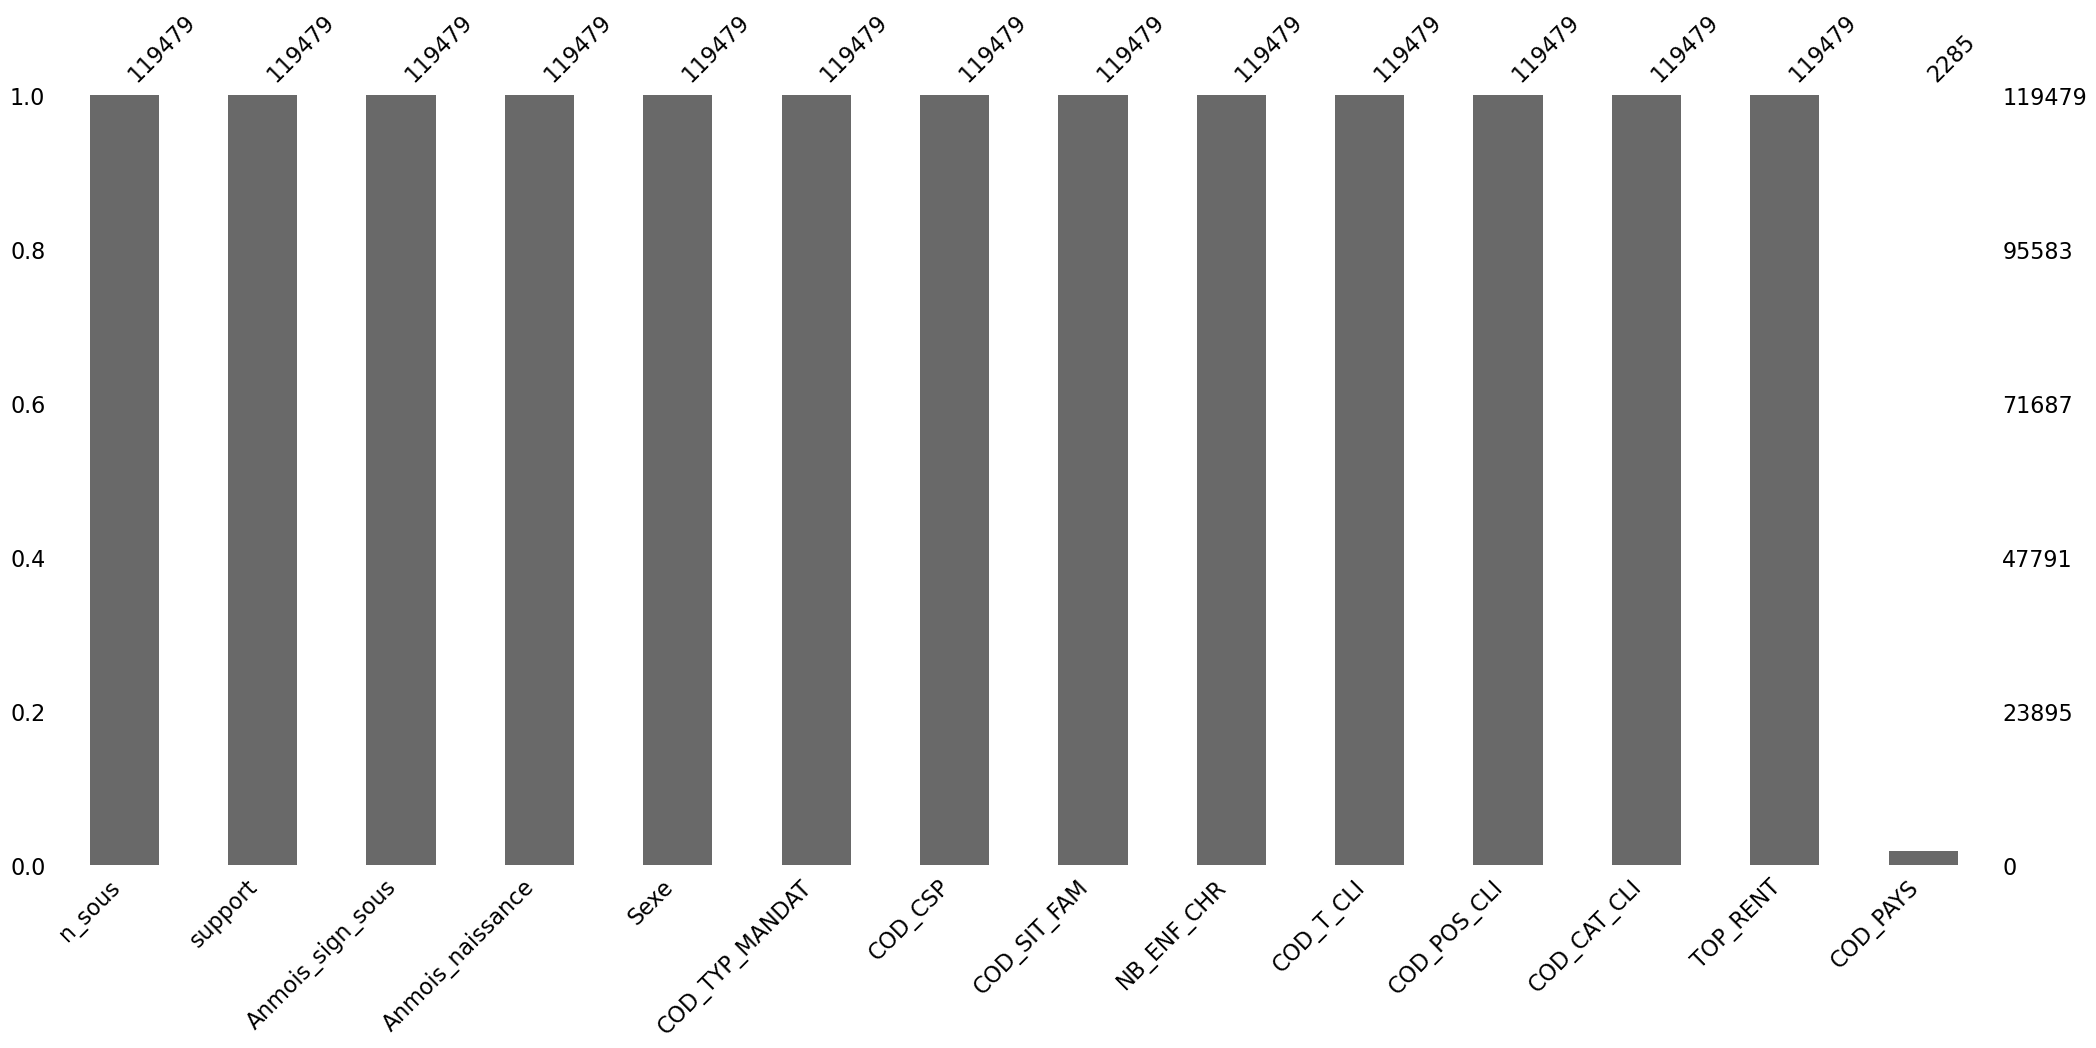

In [33]:
mso.bar(base[Variables_retenues])

Ce pendant nous avons le nombre de contrats différents suivant :

In [34]:
N=len(base['n_sous'].unique())
N

9507

#### Répartition du portefeuille suivant le type de support

Nous nous intéressons qu'aux contrats multisupports et nous avons la répartion suivant selon le type de support :

In [35]:
base_support=base[['n_sous','support']]
p=base_support.drop_duplicates(subset="n_sous")
p.groupby(by="support").count()

,n_sous
support,
FG pur,3254
Multi-supports avec FG,4629
UC pures,1624


Sur les 9507 contrats de la base de données nous allons nous restreindre aux 4629 contrats Multisupports définis comme suit :

In [36]:
#Base qui recense tous contrats multi-suppots
base_multisupport = base_updte.dropna(subset = ['support'])[base_updte.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG')]
base_multisupport['r_FG_a'] = base_multisupport['r_FG_a'].fillna(0)

# Définition des variables de durées (âge et ancienneté)
base_multisupport['annee_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(0, 4)
base_multisupport['mois_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(4, 6)
base_multisupport['annee_sign_sous'] = base_multisupport['annee_sign_sous'].astype(int)
base_multisupport['mois_sign_sous'] = base_multisupport['mois_sign_sous'].astype(int)
base_multisupport['anciennete'] = 2021 - base_multisupport['annee_sign_sous']

base_multisupport['annee_nais'] =  base_multisupport['Anmois_naissance'].astype(str).str.slice(0, 4)
base_multisupport['annee_nais'] = base_multisupport['annee_nais'].astype(int)
base_multisupport['age'] = 2021 - base_multisupport['annee_nais']

En se restreignant uniquement aux contrats ayant fait l'objet d'arbitrage, nous avons :

In [37]:
base_multisupport_arbitrage=base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages')]

### Nombre de contrats arbitrant par mois

In [38]:
comptage=base_multisupport_arbitrage[['n_sous','support','Anmois_operation','operation','CD_TYPE_SUP','montant_corr','anciennete','age']]

In [39]:
comptage_NU=base_multisupport_arbitrage[['n_sous','Anmois_operation']]
contrat_arbitre = comptage_NU.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre.rename(columns={'n_sous': 'Nombre de contrats arbitrants'}, inplace=True)
contrat_arbitre

,Anmois_operation,Nombre de contrats arbitrants
0,202101.0,427
1,202102.0,449
2,202103.0,740
3,202104.0,480
4,202105.0,422
5,202106.0,564
6,202107.0,299
7,202108.0,238
8,202109.0,551
9,202110.0,345


Au total sur notre portefeuille le nombre de contrats qui ont arbitré est de :

In [40]:
N5=len(np.unique(comptage_NU['n_sous']))
print(N5)
print("\nSoit un pourcentage de",round(100*N5/N,2),"% sur l'ensemble des contrats multisupport.") 

1734

Soit un pourcentage de 18.24 % sur l'ensemble des contrats multisupport.


#### Nombre de contrats qui ont effectué 1, 2, 3 ou plus 4 arbitrages suivant les mois

In [41]:
# On détermine de prime à bord le nombre de d'opérations d'arbitrage (EU vers UC, UC vers EU, UC vers UC) 
# par mois de chaque contrat 
contrat_mois = comptage.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
contrat_mois['operation']=(contrat_mois['operation']/2).apply(lambda x: math.ceil(x))
# Chaque contrat arbitre chaque mois 1, 2, 3 ou 4 fois 
contrat_mois['operation'].unique()

array([1, 2, 3, 4])

In [42]:
# Utiliser pour évaluer le nombre de contrats total arbitrant 1, 2, 3 ou plus de 4 fois sur l'année
p=contrat_mois.groupby(by=['n_sous'], as_index=False).sum()

Ainsi le nombre de contrats arbitrants 1,2,3 ou plus de 4 fois suivant les mois est donné par la suite

#### Pour les contrats arbitrant une seul fois :

In [43]:
contrat_mois_1=contrat_mois[contrat_mois['operation']==1]
contrat_arbitre_1 = contrat_mois_1.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_1=contrat_arbitre_1[['Anmois_operation','n_sous']]
contrat_arbitre_1.rename(columns={'n_sous': 'Nombre de contrats arbitrants 1 fois'}, inplace=True)
contrat_arbitre_1

,Anmois_operation,Nombre de contrats arbitrants 1 fois
0,202101.0,360
1,202102.0,342
2,202103.0,215
3,202104.0,337
4,202105.0,291
5,202106.0,308
6,202107.0,238
7,202108.0,211
8,202109.0,481
9,202110.0,273


#### Total des contrats qui arbitrent 1 fois sur l'année :

Dans le portefeuille le nombre de contrats ayant arbitré 1 fois aucours de l'année est de :

In [44]:
N1= (p[p['operation']==1])['n_sous'].count()
N1

495

#### Pour les contrats arbitrants deux fois :

In [45]:
contrat_mois_2=contrat_mois[contrat_mois['operation']==2]
contrat_arbitre_2 = contrat_mois_2.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_2=contrat_arbitre_2[['Anmois_operation','n_sous']]
contrat_arbitre_2.rename(columns={'n_sous': 'Nombre de contrats arbitrants 2 fois'}, inplace=True)
contrat_arbitre_2

,Anmois_operation,Nombre de contrats arbitrants 2 fois
0,202101.0,66
1,202102.0,95
2,202103.0,504
3,202104.0,137
4,202105.0,126
5,202106.0,102
6,202107.0,57
7,202108.0,25
8,202109.0,68
9,202110.0,69


Dans le portefeuille le nombre de contrats ayant arbitré 2 fois aucours de l'année est de :

In [46]:
N2= (p[p['operation']==2])['n_sous'].count()
N2

312

#### Pour les contrats arbitrant trois fois :

In [47]:
contrat_mois_3=contrat_mois[contrat_mois['operation']==3]
contrat_arbitre_3 = contrat_mois_3.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_3=contrat_arbitre_3[['Anmois_operation','n_sous']]
contrat_arbitre_3.rename(columns={'n_sous': 'Nombre de contrats arbitrants 3 fois'}, inplace=True)
contrat_arbitre_3

,Anmois_operation,Nombre de contrats arbitrants 3 fois
0,202101.0,1
1,202102.0,11
2,202103.0,21
3,202104.0,6
4,202105.0,5
5,202106.0,154
6,202107.0,4
7,202108.0,2
8,202109.0,2
9,202110.0,3


Dans le portefeuille le nombre de contrats ayant arbitré 3 fois aucours de l'année est de : 

In [48]:
N3= (p[p['operation']==3])['n_sous'].count()
N3

151

#### Pour les contrats arbitrant plus de quatre fois :

In [49]:
contrat_mois_4=contrat_mois[contrat_mois['operation']>=4]
contrat_arbitre_4 = contrat_mois_4.groupby(by=['Anmois_operation'], as_index=False).nunique()
contrat_arbitre_4=contrat_arbitre_4[['Anmois_operation','n_sous']]
contrat_arbitre_4.rename(columns={'n_sous': 'Nombre de contrats arbitrants 4 fois'}, inplace=True)
contrat_arbitre_4

,Anmois_operation,Nombre de contrats arbitrants 4 fois
0,202102.0,1


Dans le portefeuille le nombre de contrats ayant arbitré plus de 4 fois aucours de l'année est de : (Notons qu'il y'a des contrats qui ont arbitré plus de 20 fois)

In [50]:
N4=(p[p['operation']>=4])['n_sous'].count()
N4

776

### Pour ce qui est du nombre Total d'opérations d'arbitrages par mois nous avons :

In [51]:
Nb_contrat =contrat_mois.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat=Nb_contrat[['Anmois_operation','operation']]
Nb_contrat.rename(columns={'operation': 'Nombre d arbitrages'}, inplace=True)
Nb_contrat

,Anmois_operation,Nombre d arbitrages
0,202101.0,495
1,202102.0,569
2,202103.0,1286
3,202104.0,629
4,202105.0,558
5,202106.0,974
6,202107.0,364
7,202108.0,267
8,202109.0,623
9,202110.0,420


Nombre Total d'opérations arbitrages sur l'année :

In [52]:
N6=Nb_contrat['Nombre d arbitrages'].sum()
N6

7297

### Maintenant nous avons les statitiques du portefeuille en nombre de contrats arbitrants et nombre d'arbitrages suivants : 

In [53]:
dataframes=[contrat_arbitre_1,contrat_arbitre_2,contrat_arbitre_3,contrat_arbitre_4,contrat_arbitre,Nb_contrat]
stat = dataframes[0]
for df in dataframes[1:]:
    stat = pd.merge(stat, df, on='Anmois_operation', how='outer')
stat.fillna(0, inplace=True)
stat =stat.astype(int)
#Convertir la colonne Anmois_opération
from datetime import datetime
stat['Anmois_operation'] = pd.to_datetime(stat['Anmois_operation'], format='%Y%m')
stat['Anmois_operation'] = stat['Anmois_operation'].dt.strftime('%B %Y')
stat['Anmois_operation'] = stat['Anmois_operation'].astype(str)
stat.loc[len(stat)] = ['ENSEMBLE',N1,N2,N3,N4,N5,N6]
stat = stat.set_index('Anmois_operation')
stat

,Nombre de contrats arbitrants 1 fois,Nombre de contrats arbitrants 2 fois,Nombre de contrats arbitrants 3 fois,Nombre de contrats arbitrants 4 fois,Nombre de contrats arbitrants,Nombre d arbitrages
Anmois_operation,,,,,,
January 2021,360,66,1,0,427,495
February 2021,342,95,11,1,449,569
March 2021,215,504,21,0,740,1286
April 2021,337,137,6,0,480,629
May 2021,291,126,5,0,422,558
June 2021,308,102,154,0,564,974
July 2021,238,57,4,0,299,364
August 2021,211,25,2,0,238,267
September 2021,481,68,2,0,551,623


Ce tableau présente les contrats par nombre d’arbitrages effectués. Ainsi, 1734 contrats ont été à l’origine des 7297 mouvements d’arbitrages enregistrés, et sur l'année 2021 seuls 495 contrats du portefeuille n’ont effectué qu’un seul arbitrage. Ainsi, de nombreux clients effectuent plusieurs arbitrages lors de la durée de vie des contrats, ce qui permet de supposer que des clients qui ont déjà effectués des arbitrages sont plus susceptibles d’en faire à nouveau que des clients n’ayant jamais arbitré.

### Mouvement d'arbitrage de EU vers UC

#### Nombre d'arbitrages par EU -> UC

In [54]:
#arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
#Nb_contrat_mois_EU = arbitrage_EU.groupby('Anmois_operation')['operation'].count()
#Nb_contrat_mois_EU

In [55]:
arbitrage_EU=comptage[comptage['operation']=='Arbitrages sortants du FG']
contrat_mois_EU =arbitrage_EU.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_EU=contrat_mois_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_EU=Nb_contrat_mois_EU[['Anmois_operation','operation']]
Nb_contrat_mois_EU.rename(columns={'operation': 'Nombre d arbitrages EU->UC'}, inplace=True)
Nb_contrat_mois_EU

,Anmois_operation,Nombre d arbitrages EU->UC
0,202101.0,91
1,202102.0,224
2,202103.0,118
3,202104.0,90
4,202105.0,65
5,202106.0,266
6,202107.0,68
7,202108.0,46
8,202109.0,46
9,202110.0,63


### Mouvement d'arbitrage de UC vers EU

#### Nombre d'arbitrages par EU -> UC

In [56]:
arbitrage_UC=comptage[comptage['operation']=='Arbitrages entrants du FG']
contrat_mois_UC =arbitrage_UC.groupby(by=['n_sous','Anmois_operation'], as_index=False).count()
Nb_contrat_mois_UC=contrat_mois_UC.groupby(by=['Anmois_operation'], as_index=False).sum()
Nb_contrat_mois_UC=Nb_contrat_mois_UC[['Anmois_operation','operation']]
Nb_contrat_mois_UC.rename(columns={'operation': 'Nombre d arbitrages UC->EU'}, inplace=True)
Nb_contrat_mois_UC

,Anmois_operation,Nombre d arbitrages UC->EU
0,202101.0,27
1,202102.0,110
2,202103.0,314
3,202104.0,98
4,202105.0,171
5,202106.0,78
6,202107.0,40
7,202108.0,26
8,202109.0,227
9,202110.0,52


## RESUME

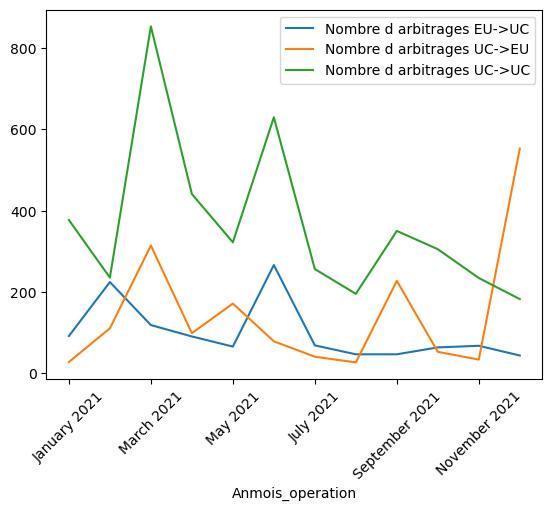

,Nombre d arbitrages EU->UC,Nombre d arbitrages UC->EU,Nombre d arbitrages UC->UC,Nombre d arbitrages
Anmois_operation,,,,
January 2021,91,27,377,495
February 2021,224,110,235,569
March 2021,118,314,854,1286
April 2021,90,98,441,629
May 2021,65,171,322,558
June 2021,266,78,630,974
July 2021,68,40,256,364
August 2021,46,26,195,267
September 2021,46,227,350,623


In [57]:
df=[Nb_contrat_mois_EU,Nb_contrat_mois_UC,Nb_contrat]
stat1 = df[0]
for df in df[1:]:
    stat1 = pd.merge(stat1, df, on='Anmois_operation', how='outer')
#Convertir la colonne Anmois_opération
from datetime import datetime
stat1['Anmois_operation'] = pd.to_datetime(stat1['Anmois_operation'], format='%Y%m')
stat1['Anmois_operation'] = stat1['Anmois_operation'].dt.strftime('%B %Y')
stat1['Anmois_operation'] = stat1['Anmois_operation'].astype(str)


stat1['Nombre d arbitrages UC->UC']=stat1['Nombre d arbitrages']-stat1['Nombre d arbitrages EU->UC']-stat1['Nombre d arbitrages UC->EU']

#Réorganisation des colonnes
stat1 = stat1[['Anmois_operation', 'Nombre d arbitrages EU->UC', 'Nombre d arbitrages UC->EU','Nombre d arbitrages UC->UC','Nombre d arbitrages']]
stat1= stat1.set_index('Anmois_operation')

M=stat1[['Nombre d arbitrages EU->UC','Nombre d arbitrages UC->EU','Nombre d arbitrages UC->UC']]
ax=M.plot()
plt.xticks(rotation=45)
#for col in M.columns:
#    for x, y in enumerate(M[col]):
#        ax.text(x, y, str(y), color='blue', fontsize=8, verticalalignment='bottom')
plt.show()

stat1.loc['TOTAL'] = stat1.sum()
stat2=stat1
stat1

 STATISTIQUES DU PORTEFEUILLE EN FONCTION DU MOUVEMENT SUR LES SUPPORTS

In [58]:
(224+266+118)/1187

0.5122156697556866

### répartition en pourcentage

In [59]:
stat2['% EU->UC']=100*(stat2['Nombre d arbitrages EU->UC']/stat2['Nombre d arbitrages'])
stat2['% UC->EU']=100*(stat2['Nombre d arbitrages UC->EU']/stat2['Nombre d arbitrages'])
stat2['% UC->UC']=100*(stat2['Nombre d arbitrages UC->UC']/stat2['Nombre d arbitrages'])
stat2[['% EU->UC','% UC->EU','% UC->UC']].round(2) 

,% EU->UC,% UC->EU,% UC->UC
Anmois_operation,,,
January 2021,18.38,5.45,76.16
February 2021,39.37,19.33,41.30
March 2021,9.18,24.42,66.41
April 2021,14.31,15.58,70.11
May 2021,11.65,30.65,57.71
June 2021,27.31,8.01,64.68
July 2021,18.68,10.99,70.33
August 2021,17.23,9.74,73.03
September 2021,7.38,36.44,56.18


A l'observation de ce tableau il est important de remarquer que sur la totalité des mouvements d’arbitrages étudiés en 2021 sur notre portefeuille, plus de la moitié des mouvements d'arbitrages soit 60,04% se font du support UC vers UC. Par ailleurs, seulement 16,27% des mouvements d'arbitrages enregistrés au total sont des arbitrages EU vers UC et donc environ 52 % de ces derniers ont été réalisés les seuls mois de février, mars et juin qui sont des mois où on note un nombre important de sortie en sur le fond en euro. Il est également important de joindre à cette analyse les montants présents et ou transférés sur chaque support à la fin de chaque mois.

## EVOLUTION DE L'ENCOURS SUR LES DIFFERENTS SUPPORTS

In [60]:
encours=base_multisupport[['n_sous','Anmois_operation','PM_UC','PM_FG','anciennete','age']]
contrat_encours=encours.groupby(by=['n_sous','Anmois_operation','PM_FG','PM_UC'], as_index=False).nunique()
contrat_encours=contrat_encours[['Anmois_operation','PM_FG','PM_UC']]
contrat_encours.rename(columns={'PM_FG': 'Encours support EU','PM_UC': 'Encours support UC'}, inplace=True)
#Convertir les données en valeur numériques 
contrat_encours[['Encours support EU', 'Encours support UC']] = contrat_encours[['Encours support EU', 'Encours support UC']].astype(float)
#Il est à noter que le contrat 9504 a des valeurs de PM_UC et PM_EU anormalement nulles

### Evolution de l'encours d'épargne sur chaque support

In [61]:
contrat_encours_moy=contrat_encours.groupby(by=['Anmois_operation'], as_index=False).mean()
#covertion de la variable Anmois en format date
contrat_encours_moy['Anmois_operation'] =pd.to_datetime(contrat_encours_moy['Anmois_operation'], format='%Y%m')
contrat_encours_moy.sort_values(by='Anmois_operation')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].dt.strftime('%B %Y')
contrat_encours_moy['Anmois_operation'] = contrat_encours_moy['Anmois_operation'].astype(str)
contrat_encours_moy=contrat_encours_moy.set_index('Anmois_operation')

# calcul de l'encours moyen annuel sur chaque support
contrat_encours_moy.loc['ENSEMBLE']=contrat_encours_moy.mean()
X=contrat_encours_moy.round(2)
X

,Encours support EU,Encours support UC
Anmois_operation,,
January 2021,209912.97,215665.70
February 2021,197107.13,222539.11
March 2021,247137.42,222244.27
April 2021,227178.61,197246.66
May 2021,216289.41,232139.65
June 2021,209207.37,198938.06
July 2021,223336.54,252014.20
August 2021,172648.87,205237.37
September 2021,211612.63,214517.91


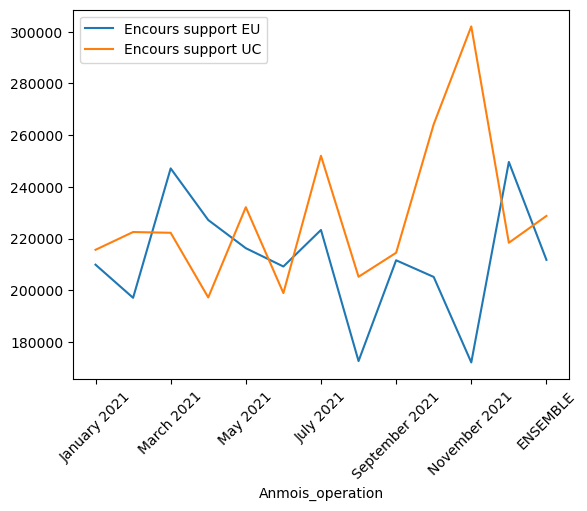

In [62]:
X[['Encours support EU','Encours support UC']].plot()
plt.xticks(rotation=45)
plt.show()

### Répartition en pourcentage

In [63]:
X['TOTAL']=X['Encours support EU']+X['Encours support UC']
X['% Encours support EU']=100*(X['Encours support EU']/X['TOTAL'])
X['% Encours support UC']=100*(X['Encours support UC']/X['TOTAL'])
Z=X[['% Encours support EU','% Encours support UC']].round(2)
Z

,% Encours support EU,% Encours support UC
Anmois_operation,,
January 2021,49.32,50.68
February 2021,46.97,53.03
March 2021,52.65,47.35
April 2021,53.53,46.47
May 2021,48.23,51.77
June 2021,51.26,48.74
July 2021,46.98,53.02
August 2021,45.69,54.31
September 2021,49.66,50.34


Là il s'agit de la répartition de l'épargne des clients à la fin de chaque mois sur différents supports UC ou EU. Nous constatons 
qu'en moyenne, de juin à decemebre la Provision mathématique sur le support UC est presque relativement plus élévée que le provision 
mathématique sur le support EU. Il serait certainement plus intéressant d'évaluer les montants totals mensuels transférés d'un support à un autre pour également mésurer l'ampleur des arbitrages, c'est ce qui est fait par la suite.

## Evolution des montants entrants et des montants sortants sur le fond en euro

### Montant sortant du FG

In [64]:
montant=comptage.copy()

In [65]:
montant['Anmois_operation'] =pd.to_datetime(montant['Anmois_operation'], format='%Y%m')

<function matplotlib.pyplot.show(close=None, block=None)>

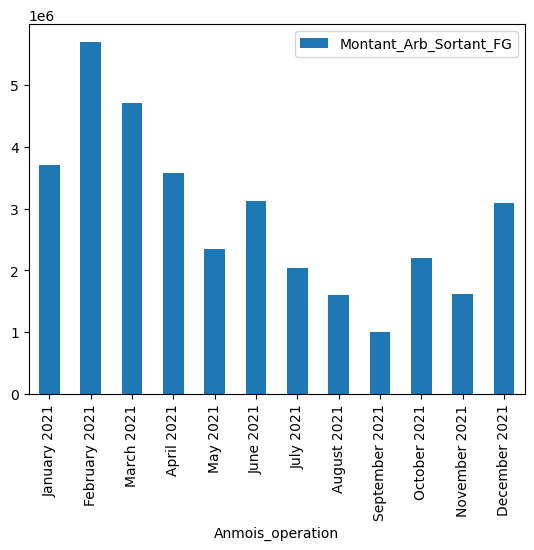

In [66]:
sortie_EU=montant[montant['operation']=='Arbitrages sortants du FG']
sortie_mois_EU = sortie_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
sortie_mois_EU=sortie_mois_EU[['Anmois_operation','montant_corr']]
sortie_mois_EU['montant_corr']=-sortie_mois_EU['montant_corr']

sortie_mois_EU.sort_values(by='Anmois_operation')
sortie_mois_EU['Anmois_operation'] = sortie_mois_EU['Anmois_operation'].dt.strftime('%B %Y')
sortie_mois_EU['Anmois_operation'] = sortie_mois_EU['Anmois_operation'].astype(str)
sortie_mois_EU=sortie_mois_EU.set_index('Anmois_operation')
sortie_mois_EU.rename(columns={'montant_corr': 'Montant_Arb_Sortant_FG'}, inplace=True)
sortie_mois_EU.plot(kind='bar')
plt.show

### Montant entrants du FG

<function matplotlib.pyplot.show(close=None, block=None)>

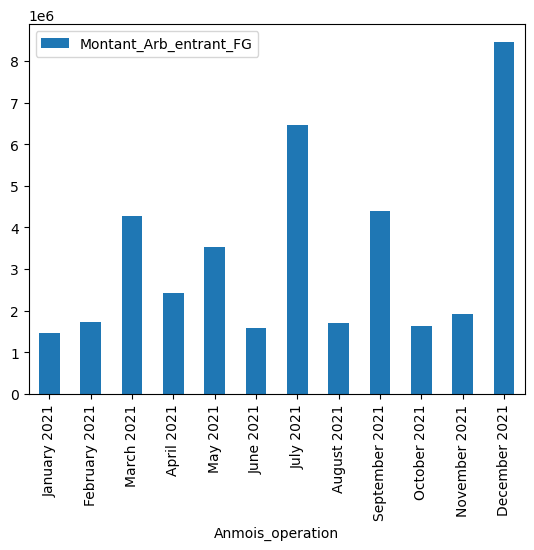

In [67]:
entrée_EU=montant[montant['operation']=='Arbitrages entrants du FG']
entrée_mois_EU = entrée_EU.groupby(by=['Anmois_operation'], as_index=False).sum()
entrée_mois_EU=entrée_mois_EU[['Anmois_operation','montant_corr']]

entrée_mois_EU.sort_values(by='Anmois_operation')
entrée_mois_EU['Anmois_operation'] = entrée_mois_EU['Anmois_operation'].dt.strftime('%B %Y')
entrée_mois_EU['Anmois_operation'] = entrée_mois_EU['Anmois_operation'].astype(str)
entrée_mois_EU=entrée_mois_EU.set_index('Anmois_operation')
entrée_mois_EU.rename(columns={'montant_corr':'Montant_Arb_entrant_FG'}, inplace=True)
entrée_mois_EU.plot(kind='bar')
plt.show

,Montant_Arb_Sortant_FG,Montant_Arb_entrant_FG
Anmois_operation,,
January 2021,3710163.86,1471197.58
February 2021,5698473.71,1725482.92
March 2021,4713379.32,4275176.28
April 2021,3576324.66,2423209.39
May 2021,2348432.77,3539367.92
June 2021,3123403.68,1582203.19
July 2021,2039011.86,6463142.23
August 2021,1608089.47,1711674.98
September 2021,996488.66,4401315.91


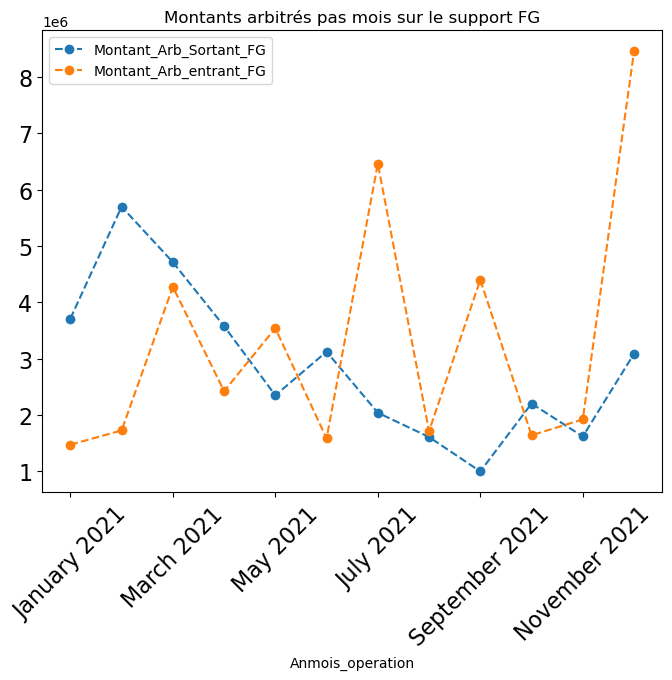

In [68]:
sortie_mois_EU['Montant_Arb_entrant_FG']=entrée_mois_EU['Montant_Arb_entrant_FG']
sortie_mois_EU.plot(marker="o",linestyle="dashed",title="Montants arbitrés pas mois sur le support FG",figsize=(8, 6),fontsize=16)
plt.xticks(rotation=45)
plt.show
sortie_mois_EU

Le flux d'arbitrage sur le suppport fond en euro est donné par le graphe suivant :

<function matplotlib.pyplot.show(close=None, block=None)>

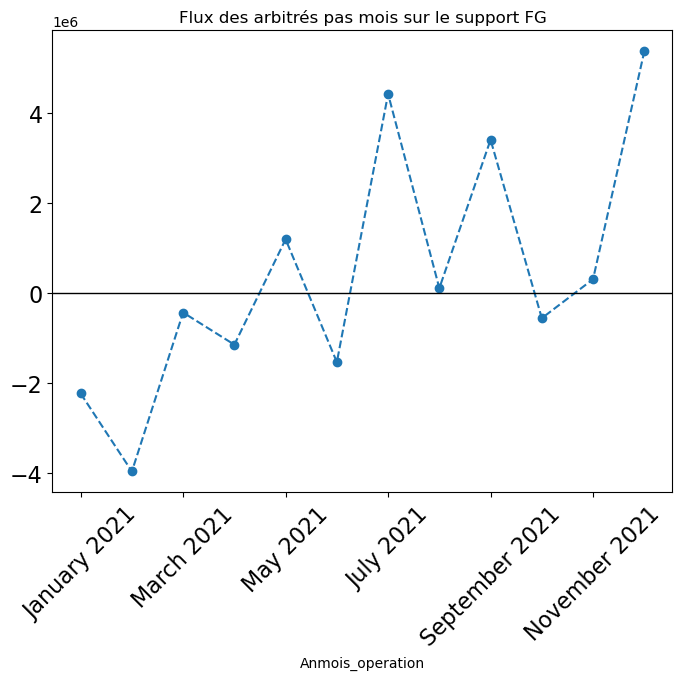

In [69]:
sortie_mois_EU['flux_Arb__FG']=sortie_mois_EU['Montant_Arb_entrant_FG']-sortie_mois_EU['Montant_Arb_Sortant_FG']
sortie_mois_EU['flux_Arb__FG'].plot(marker="o",linestyle="dashed",title="Flux des arbitrés pas mois sur le support FG",figsize=(8, 6),fontsize=16)
plt.axhline(y=0, color='black', linewidth=1)
plt.xticks(rotation=45)
plt.show

Le solde entrée-sotie sur le support fond en euro est négatif de janvier à juin excepté le mois de mai, ce resultat rejoint l'analyse 
faite précédemment où nous avons constaté que le nombre de mouvements d'arbitrages sortants du fond en euro était plus important 
au mois de février, mars et juin. Cela signifie qu’il y a plus de sortie du fonds euros que d’entrée. Cette période pourrait 
certainement coïncider avec une conjoncture financière haussière. Pour s'en assurer, nous allons croiser ce resultat avec celui 
de l'évolution des rendements du CAC 40 durant l'année 2021.

### Evolution du CAC 40 et du CAC All-Tradable 2021

In [70]:
#Données sur l'évolution du cours du CAC 40 en 2021
CAC_40_monthly_2021= get_data("^FCHI", start_date="01/01/2021", end_date="12/31/2021", index_as_date = True, interval="1mo")
CAC_40_monthly_2021

,open,high,low,close,adjclose,volume,ticker
2020-12-31,5614.040039,5721.890137,5379.220215,5399.209961,5399.209961,1890232300,^FCHI
2021-01-31,5441.430176,5834.359863,5429.779785,5703.220215,5703.220215,1653472600,^FCHI
2021-02-28,5770.890137,6097.740234,5755.600098,6067.229980,6067.229980,1790816900,^FCHI
2021-03-31,6079.669922,6352.359863,6063.859863,6269.479980,6269.479980,1131002300,^FCHI
2021-04-30,6285.509766,6496.319824,6150.430176,6447.169922,6447.169922,1406929000,^FCHI
2021-05-31,6470.419922,6687.290039,6464.709961,6507.830078,6507.830078,1498795900,^FCHI
2021-06-30,6549.819824,6671.120117,6253.250000,6612.759766,6612.759766,1235050200,^FCHI
2021-07-31,6657.950195,6913.669922,6560.740234,6680.180176,6680.180176,1307673500,^FCHI
2021-08-31,6736.439941,6784.660156,6389.620117,6520.009766,6520.009766,1895499000,^FCHI
2021-09-30,6421.100098,6830.339844,6412.700195,6830.339844,6830.339844,1580696700,^FCHI


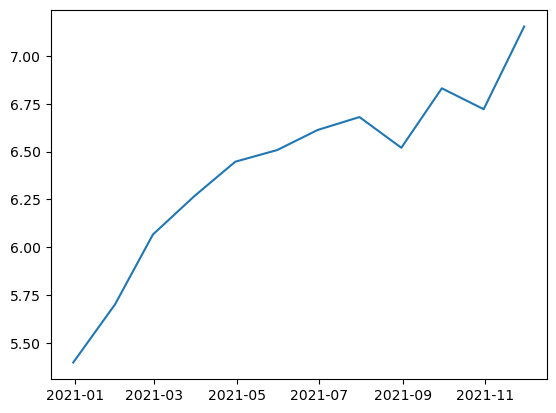

In [71]:
plt.plot(CAC_40_monthly_2021.index, CAC_40_monthly_2021['adjclose']/1000, label='valeur du CAC 40')

### Web scraping des données sur l'évolution du CAC All-Tradable sur le site web Investing.com
(l'indice le plus répresentatif de la santé de l'économie française)

In [72]:
# URL de la page
url = 'https://fr.investing.com/indices/cac-all-tradable-historical-data'

# Envoi de la requête HTTP
response = requests.get(url, headers=headers)

# Analyse du contenu HTML
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'class': 'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})

# Extraction des données du tableau
rows = table.find_all('tr')
data = []
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])  # Éliminer les données vides

# Convertir les données en DataFrame pandas pour un affichage plus lisible
donnees_cac_all_tradable = pd.DataFrame(data, columns=['Date','Dernier','Ouv.', 'Plus Haut','Plus Bas','Vol.','Variation %']) 
donnees_cac_all_tradable

NameError: name 'headers' is not defined

In [ ]:

# URL de la page
url = 'https://fr.investing.com/indices/cac-all-tradable-historical-data'

# Envoi de la requête HTTP
response = requests.get(url, headers=headers)
# Analyse du contenu HTML
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'class':'w-full text-xs leading-4 overflow-x-auto freeze-column-w-1'})

# Extraction des données du tableau
rows = table.find_all('tr')
data = []
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])  # Éliminer les données vides

# Convertir les données en DataFrame pandas pour un affichage plus lisible
donnees_cac_all_tradable = pd.DataFrame(data, columns=['Date','Dernier','Ouv.', 'Plus Haut','Plus Bas','Vol.','Variation %'])

# Convertir la colonne 'Date' en datetime
donnees_cac_all_tradable['Date'] = pd.to_datetime(donnees_cac_all_tradable['Date'], format='%d/%m/%Y')

# Filtrer pour obtenir uniquement les données de 2021
donnees_2021 = donnees_cac_all_tradable[donnees_cac_all_tradable['Date'].dt.year == 2021]

# Afficher le DataFrame filtré
print(donnees_2021)

In [ ]:
!pip install investpy
import investpy
debut = '01/01/2020'
fin = '31/12/2020'
donnees_cac_all_tradable = investpy.indices.get_index_historical_data(index='CAC All-Tradable',country='france',from_date=debut,to_date=fin)
print(donnees_cac_all_tradable)

In [ ]:
plt.plot(CAC_40_monthly_2021.index, CAC_40_monthly_2021['volume']/1000, label='valeur du CAC 40')
plt.plot(sortie_mois_EU.index, sortie_mois_EU['flux_Arb__FG'], label='Flux entrée-sortie FG')
plt.xlabel('Index')  
plt.ylabel('Valeurs') 
plt.title('Evolution du CAC 40 et du Flux entrée-sortie FG ') 
plt.legend()
plt.show()

Nous pouvons penser qu’il y a un lien entre les mouvements d’arbitrage et la fluctuation des cours du CAC 40, ou d’une manière
générale de la conjoncture financière et économique. En effet, 


   
    
Nous pouvons également par la suite éffectuer un test pour confirmer l'existente d'une corrélation négative entre le cours du CAC 40
et le solde entrée-sortie du fond en euro. Ce résultat confirmerait que lorsque le CAC40 augmente les épargnants ont tendance à
quitter le fonds euros au profit des unités de compte et ceci vice versa.

## ANALYSES DESCRIPTIVES BIVAREES

In [ ]:
#Base dans laquelle un individu est un contrat multisupport
base_contrats = base_multisupport.drop_duplicates(subset=['n_sous'], keep='first')
base_arbitrage_FG_update = base_multisupport.dropna(subset = ['operation'])[base_multisupport.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]

### Arbitrage et Ancienneté du Contrat

In [ ]:
# Grouper par année et compter le nombre de contrats par année
arbitrages_par_annee = base_contrats.groupby('anciennete')['operation'].count()

#Graphique
plt.figure(figsize=(10, 10))
arbitrages_par_annee.plot(kind='bar', xlabel='Ancienneté', ylabel='Nombre de contrats' , title="Evolution du nombre de contrats qui arbitrent selon l'ancienneté")
plt.show()

La majorité des contrats qui ont arbitré au moins une fois (peu importe le mouvement), ont une ancienneté comprise entre 20 et 30 ans.

In [ ]:
#Regroupement de l'ancienneté en classes
bins = [4, 8, 12, 16, 20, 24, 28, 32, 36, 100]


# Création des classes
base_arbitrage_FG_update['anciennete2'] = pd.cut(base_arbitrage_FG_update['anciennete'], bins=bins, labels=['[4; 8]', '[8; 12]','[12; 16]', '[16; 20]', '[20; 24]', '[24; 28]', '[28; 32]', '[32; 36]', '[36; 100]'])
counts = base_arbitrage_FG_update['anciennete2'].value_counts()
plt.figure(figsize=(10, 10))
sns.boxplot(x='anciennete2', y='r_FG_a', data=base_arbitrage_FG_update, showfliers = False, width= counts/len(base_arbitrage_FG_update))
means = base_arbitrage_FG_update.groupby('anciennete2')['r_FG_a'].apply(gmean)
for i, mean in enumerate(means):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='red')
plt.xlabel("Classes d'ancienneté")
plt.ylabel("taux d'arbitrage annualisé")
plt.title("Boxplot des taux d'arbitrage en fonction des classes d'ancienneté \n (La largeur des boîtes est proportionnelle aux mouvements d'arbitrage concernés par la boîte)")
plt.show()

Graphiquement, on peut constater que ces contrats qui sont majoritaires dans la base (entre 20 et 30 années d'ancienneté), souscrits entre 1991 et 2001, arbitrent des proportions de leur PM moindres, comparé aux contrats souscrits après 2005. De plus, ces derniers effectuent le plus de mouvements d'arbitrages

In fine, concernant l'ancienneté, on retient les points suivants :
- La base est constituée en majorité des contrats souscrits entre 1991 et 2001;
- Ces derniers par contre n'effectuent pas énormément de mouvement d'arbitrages;
- Et Bien même, lorsqu'ils arbitrent, ils arbitrent des proportions de leur Provision Mathématique inférieure à celle arbitrée par les contrats souscrits après 2005.

In [ ]:
#sns.kdeplot(data=base_contrats, x='r_FG_a', palette='Set2')
#plt.hist(base_contrats['r_FG_a'], bins=10, edgecolor='black')

### Arbitrage et âge

In [ ]:
#Graphique
plt.figure(figsize=(20, 20))
base_contrats.groupby('age')['operation'].count().plot(kind='bar', xlabel='Age', ylabel='Nombre de contrats' , title="Evolution du nombre de contrats qui arbitrent selon l'age")
plt.show()

La majorité des contrats qui ont effectué au moins un arbitrage (peu importe lequel) a entre 60 et 90 ans.

In [ ]:
#Regroupement de l'ancienneté en classes
bins = list(range(20, 101,10))

# Création des classes
base_arbitrage_FG_update['age2'] = pd.cut(base_arbitrage_FG_update['age'], bins=bins, labels=['[20; 30]', '[30; 40]', '[40; 50]','[50; 60]', '[60; 70]', '[70; 80]', '[80; 90]', '[90; 100]'])

counts = base_arbitrage_FG_update['age2'].value_counts()
plt.figure(figsize=(10, 10))
sns.boxplot(x='age2', y='r_FG_a', data=base_arbitrage_FG_update, showfliers=False, width= 0.5 * counts/len(base_arbitrage_FG_update))
means = base_arbitrage_FG_update.groupby('age2')['r_FG_a'].apply(gmean)
for i, mean in enumerate(means):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
plt.xlabel("Age en classes")
plt.ylabel("taux d'arbitrage annualisé")
#plt.yticks(np.arange(0, 100, 5))
plt.title("Boxplot des taux d'arbitrage en fonction des classes d'age \n (La largeur des boîtes est proportionnelle aux mouvements d'arbitrage concernés par la boîte)")
plt.show()

La proportion de la Provision Mathématique FG arbitrée est croissante avec l'âge, jusqu'à un certain seuil, environ 55 ans à partir duquel cette proportion devient décroissante. Après la retraite, les taux d'arbitrages sont donc les plus bas.
--> Ceci nous fait penser à un effet quadratique de l'âge sur le taux d'arbitrage.

De plus, plus on est jeune, ce sont les plus jeunes, âgés de moins de 45 ans qui effectuent le plus les mouvements d'arbitrages FG.



### Arbitrage et Sexe

In [ ]:
counts = base_arbitrage_FG_update['Sexe'].value_counts()
plt.figure(figsize=(10, 10))
sns.boxplot(x='Sexe', y='r_FG_a', data=base_arbitrage_FG_update, showfliers=False, width= 0.5 * counts/len(base_arbitrage_FG_update))
means = base_arbitrage_FG_update.groupby('Sexe')['r_FG_a'].apply(gmean)
for i, mean in enumerate(means):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
    plt.text(i, mean, f'{counts.iloc[i]}', ha='center', va='top', color='red')
plt.xlabel("Sexe")
plt.ylabel("taux d'arbitrage")
plt.title("Taux d'arbitrage en fonction du sexe")
plt.show()

Quant au sexe, les hommes effectuent un peu plus de mouvements d'arbitrages sortant FG que les femmes, et leurs taux sont un peu plus bas que ceux des femmes.

# Description de la durée minimum et maximum des contrats 

In [ ]:
duree=base_multisupport[["n_sous","DUR_MIN_SOUS","DUR_MAX_SOUS","r_FG_a","DUR_SOUS"]]
duree=duree.drop_duplicates()
duree.set_index('n_sous', inplace=True)
values=duree['DUR_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='red')
# Add labels and title
plt.xlabel('Durée de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats selon la durée de souscriptions')
# Show the plot
plt.show()



In [ ]:
values=duree['DUR_MIN_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='blue')
# Add labels and title
plt.xlabel('Durée minimale de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon la durée minimale de souscriptions')

# Show the plot
plt.show()

In [ ]:
values=duree['DUR_MAX_SOUS'].value_counts()
# Plot a bar chart
plt.bar(values.index, values, color='blue')
# Add labels and title
plt.xlabel('Durée maximale de souscriptions en années')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon la durée maximale de souscriptions')

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(duree['r_FG_a'], bins=40, color='red', kde=True)
plt.title("Distribution du taux d'arbitrage annuel des clients de BNP")
plt.xlabel("Taux d'arbitrage annuel")
plt.ylabel('Frequence/Densité')
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = duree[['DUR_MIN_SOUS','DUR_MAX_SOUS','r_FG_a','DUR_SOUS']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)

# Set plot title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [ ]:
def custom_function(row):
    if (row['r_FG_a'] == 0):
        return 0
    else:
        return 1
duree['arbitrage']=duree.apply(custom_function,axis=1)
duree.boxplot(column='DUR_MIN_SOUS', by='arbitrage',grid=False)
# Set plot labels and title
plt.title('Box Plot de la durée minimale par categorie')
plt.xlabel('Categorie (0: non-arbitrage vs 1:arbitrage)')
plt.ylabel('Durée minimale de souscription')

# Mandat d’arbitrage, Taux minimale garantie

In [ ]:
mandat=base_multisupport[['TOP_GAR','COD_TYP_MANDAT','r_FG_a']]

In [ ]:
mandat.boxplot(column='r_FG_a', by='COD_TYP_MANDAT',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par type de mandat")
plt.xlabel('')
plt.ylabel("Taux d'arbitrage annuel")

In [ ]:
mandat.boxplot(column='r_FG_a', by='TOP_GAR',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par l'existence d'une garantie ou pas")
plt.xlabel('')
plt.ylabel("Taux d'arbitrage annuel")

In [ ]:
from scipy.stats import f_oneway,ttest_ind
# Statistical Test (ANOVA)
category_1_values = mandat[mandat['TOP_GAR'] == 0.0]['r_FG_a']
category_2_values = mandat[mandat['TOP_GAR'] == 1.0]['r_FG_a']

t_statistic, p_value = ttest_ind(category_1_values, category_2_values)
print(f'T-statistic: {t_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les deux categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les deux categories. Donc une relation d'indépendance")

In [ ]:
from scipy.stats import f_oneway
# Statistical Test (ANOVA)
category_0_values = mandat[mandat['COD_TYP_MANDAT'] == 0]['r_FG_a']
category_1_values = mandat[mandat['COD_TYP_MANDAT'] == 1]['r_FG_a']
category_2_values = mandat[mandat['COD_TYP_MANDAT'] == 2]['r_FG_a']
category_4_values = mandat[mandat['COD_TYP_MANDAT'] == 4]['r_FG_a']

f_statistic, p_value = f_oneway(category_0_values, category_1_values, category_2_values, category_4_values )
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les quatre categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les quatre categories. Donc une relation d'indépendance")

# Analyse suivant le code fiscal 

In [ ]:
fisc=base_multisupport[["Anmois_arrete","n_sous","Anmois_eff_fisc","MTTC_PRI_FISC98","MT_VAC_FISC98","COD_FIS","r_FG_a","r_FG_m"]]
fisc['Anmois_eff_fisc'] = pd.to_datetime(fisc['Anmois_eff_fisc'], format='%Y%m')
fisc['Anmois_arrete'] = pd.to_datetime(fisc['Anmois_arrete'], format='%Y%m')

In [ ]:
liste=fisc['n_sous'].unique().tolist()
plt.figure(figsize=(10, 6))
for i in liste:
    data=fisc[fisc['n_sous']==i]
    plt.plot(data['Anmois_arrete'], data["MTTC_PRI_FISC98"])
plt.title('Evolution du montant TTC des primes versées soumises à la fiscalité 98')
plt.xlabel('Mois-année')
plt.ylabel('montant TTC des primes versées soumises à la fiscalité 98')
plt.legend()
plt.show() 

In [ ]:
liste=fisc['n_sous'].unique().tolist()
plt.figure(figsize=(10, 6))
for i in liste:
    data=fisc[fisc['n_sous']==i]
    plt.plot(data['Anmois_arrete'], data["MT_VAC_FISC98"])
plt.title('Evolution de la valeur acquise de la fiscalité 98')
plt.xlabel('Mois-année')
plt.ylabel('Montant valeur acquise de la fiscalité 98')
plt.legend()
plt.show()

In [ ]:
l=fisc[['COD_FIS','n_sous']].drop_duplicates().set_index("n_sous")
codfisc=pd.Series(l.value_counts()).reset_index()
codfisc.set_index('COD_FIS', inplace=True)
# Plot a bar chart
codfisc.plot(kind='bar', color='blue', edgecolor='black', alpha=0.7, legend=False)
# Add labels and title
plt.xlabel('Code fiscal (1: Rachat, 2: Rente vs 3: Fiscalité en cas de décès)')
plt.ylabel('Effectif')
plt.title('Distribution des contrats de souscriptions selon leur type de fiscalité')

# Show the plot
plt.show()

In [ ]:
fisc.boxplot(column='r_FG_a', by='COD_FIS',grid=False)
# Set plot labels and title
plt.title("Box Plot du taux d'abritrage annuel par fiscalité par categorie")
plt.xlabel('Code fiscal (1: Rachat, 2: Rente vs 3: Fiscalité en cas de décès)')
plt.ylabel("Taux d'arbitrage annuel")

In [ ]:
# Statistical Test (ANOVA)
category_1_values = fisc[fisc['COD_FIS'] == 1]['r_FG_a']
category_2_values = fisc[fisc['COD_FIS'] == 2]['r_FG_a']
category_3_values = fisc[fisc['COD_FIS'] == 3]['r_FG_a']

f_statistic, p_value = f_oneway(category_1_values, category_2_values, category_3_values)
print(f'F-statistic: {f_statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Il y a une difference significative entre les trois categories. Donc une relation de dépendance")
else:
    print("Il y a pas de difference significative entre les trois categories. Donc une relation d'indépendance")

In [ ]:
# Calculate the correlation matrix
correlation_matrix = fisc[['MT_VAC_FISC98','MTTC_PRI_FISC98','r_FG_a','r_FG_m']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)

# Set plot title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

# Modélisation: regression Linéaire

### 1- Conversion de variables

In [ ]:
base_test=base_multisupport[['n_sous','Sexe','TOP_2TETE','COD_BEN_VIE','TOP_BEN_ACPT','COD_POS_SOUS','COD_VRS','TOP_MEG','TOP_NUPROP','TOP_COSOUS','TOP_K_DEMBRT','TOP_PROCU','TOP_DEROG_FRAIS_ARB','TOP_CONTRAT_DIVERSIFIE','TOP_HANDICAP','NB_ENF_CHR','COD_POS_CLI',
 'COD_T_CLI',
 'COD_CAT_CLI','TOP_2ASS','TOP_GES_PAR',
 'TOP_RENT',
 'TOP_SICAV',
 'TOP_GAR',
 'TOP_ASSU',
 'TOP_ASSU_OTO',
 'TOP_CPT_OPT',
 'TOP_ISF',
 'TOP_DIVS',
 'COD_PAYS',
 'TOP_VIE_ENT','COD_INSEE',
 'COD_PTT_COUR',
 'COD_PAYS_COUR',
 'TOP_SENSIBLE',
 'TOP_NPAI_COUR','COD_T_PRI',
 'TOP_CONTRAT_GPE',
 'DUR_MIN_SOUS',
 'DUR_MAX_SOUS','COD_CAT_CCA_FRC','TOP_EP_PROG','r_FG_a']].drop_duplicates()

In [ ]:
base_test=base_test.set_index('n_sous')

In [ ]:
value={1:"Oui",0:"Non"}
for i in base_test.columns.tolist():
    if (i[:3]=='TOP'):
            base_test[i]=base_test[i].replace(value)
            base_test[i].astype('str')

In [ ]:
base_test.info()

In [ ]:
values={1:'Contrats de capitalisation en euros à prime unique ou versements libres',2:'Contrats de capitalisation en euros à primes périodiques',42:'Autres contrats individuels dassurance vie à prime unique ou versements libres',52:'Autres contrats individuels dassurance vie à primes périodiques',72:'Autres contrats collectifs en cas de vie',111:'Contrats PERP -partie FG'}
base_test['COD_CAT_CCA_FRC']=base_test['COD_CAT_CCA_FRC'].replace(values).astype('str')
value1={1:'bénéficiaire désigné sans clause par défaut',2:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',3:'à ses héritiers',4:'ou à défaut aux héritiers du souscripteur',6:'à son conjoint, ou à défaut, à ses enfants ou ses héritiers',7:'conformément aux souhaits que vous avez exprimés',8:' à ses enfants ou à défaut ses héritiers',11:'à mes enfants vivants ou représentés, ou à défaut mes héritiers'}
#base_test['COD_BEN_DC']=base_test['COD_BEN_DC'].replace(value1)
value2={1:'pas de bénéficiaire',2:'au souscripteur',5:'au conjoint à la date de décès, ou à défaut à mes enfants vivants ou représentés, ou à défaut mes héritiers',6:'à des bénéficiaires selon une liste'}
base_test['COD_BEN_VIE']=base_test['COD_BEN_VIE'].replace(value2).astype('str')
value3={5:'En cours, lassuré paie',6:'En cours, lassuré ne paie plus'}
base_test['COD_POS_SOUS']=base_test['COD_POS_SOUS'].replace(value3).astype('str')
value4={1:'chèque, espèce, mandat, titre',2:'PO sponsor',3:'Carte de crédit',6:'PO banque',7:'PO banque',8:'en attente', 9:'inconnu'}
base_test['COD_VRS']=base_test['COD_VRS'].replace(value4).astype('str')
#value5={0:'présouscription',1:'souscription',2:'modification épargne programmée',3:'changement de produit',4:'rachat partiel',5:'arbitrage', 6:'rachat total', 7:'changement caractéristiques contrat',8:'Versement exceptionnel',9:'Fin de contrat',10:'mouvements combinés',11:'changement/renouvellement de TMG',12:'remboursement sur fin de contrats',13:'décès',14:'création/modification/suppression indexation',15:'tombée prime programmée'}
#base_test['COD_MVT_SC']=base_test['COD_MVT_SC'].replace(value5)
#value6={0:'non renseigné',1:'célibataire',2:'marié',3:'veuf',4:'Divorcé',5:'vie maritale', 9:'Inconnu'}
#base_test['COD_SIT_FAM']=base_test['COD_SIT_FAM'].replace(value6)
value7={1:'actif',2:'prospect',3:'décédé',4:'annulé'}
base_test['COD_POS_CLI']=base_test['COD_POS_CLI'].replace(value7).astype('str')
value8={1:'Anonyme',2:'Personne physique',3:'Personne morale',4:'Mineur',5:'Incapable majeur',6:'Individsion',7:'Incapable majeur'}
base_test['COD_T_CLI']=base_test['COD_T_CLI'].replace(value8).astype('str')
value9={1:'Externe',2:'Groupe',7:'famille',8:'entreprise'}
base_test['COD_CAT_CLI']=base_test['COD_CAT_CLI'].replace(value7).astype('str')

In [ ]:
base_test.info()

In [ ]:
X=base_test.drop('r_FG_a',axis=1)
y=base_test['r_FG_a']

In [ ]:
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np
cat=[]
num=[]
for i in X.columns:
    if (X[i].dtypes=="object"):
        cat.append(i)
    else:
        num.append(i)
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
        (StandardScaler(), num),
        (OneHotEncoder(handle_unknown = 'ignore'), cat))

In [ ]:
X[cat]=X[cat].astype('str')

In [ ]:
# Create the Lasso Regression model
lasso_model = LinearRegression()  # Adjust alpha according to your needs

# Create the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', lasso_model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline.fit(X_train, y_train)

In [ ]:
X_test[cat]=X_test[cat].astype('str')
# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Evaluate the model (e.g., with Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [ ]:
# Récupérer le modèle Lasso du pipeline
lasso_regression_model = pipeline.named_steps['lasso']

# Accéder aux coefficients
coefficients = lasso_regression_model.coef_

# Afficher les coefficients
for i, v in enumerate(coefficients):
    print('Feature: %0d, Score: %.5f' % (i, v))

# Plot feature importance
plt.bar([x for x in range(len(coefficients))], coefficients)
plt.show()

In [ ]:
pip install dalex

In [ ]:
import dalex as dx
X_test = X_test.reset_index(drop=True)

In [ ]:
exp_tree1 = dx.Explainer(pipeline, X_test, y_test, verbose=False)

In [ ]:
exp_tree1.model_parts().plot()